In [7]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_sampling, get_crossover, get_mutation
from pymoo.model.problem import Problem
from pymoo.optimize import minimize

#%matplotlib qt
import PlotUtil
from hermes.postprocessing import get_r_ab_sff, generate_grouped_passed_df, generate_pass_range_list
from notebooks.optimization_problems.link_budget_problem_real_power import LinkBudgetProblemRealPower
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "example_data.h5"

row_limit = -1

store_500km = pd.HDFStore(file_path)

instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_500km_df = instances_500km_df.sort_index(0)

In [9]:
N_passes = 20

instances_df = instances_500km_df.loc[0:N_passes,:]

In [27]:
from notebooks.optimization_problems.link_budget_problem import LinkBudgetProblem
from notebooks.optimization_problems.link_budget_problem_real_power import LinkBudgetProblemRealPower
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

import multiprocessing
from notebooks.optimization_problems.contact_problem import ContactProblem

# the number of processes to be used
n_proccess = 8
pool = multiprocessing.Pool(n_proccess)

sys_param = SystemParameters()
sys_param.Ptx_dBm_list = np.arange(10, 40, 0.5).tolist()

#problem = LinkBudgetProblem(instances_df, sys_param, parallelization = ('starmap', pool.starmap))
problem = LinkBudgetProblem(instances_df, sys_param)
problem = LinkBudgetProblemRealPower(instances_df, sys_param)
#problem = LinkBudgetProblemRealPower(instances_df, sys_param, parallelization = ('starmap', pool.starmap))

sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices, real_power=True)

converge_algo_settings = {'pop_size': 100, 'n_offsprings': 100}
unconverge_algo_settings = {'pop_size': 100, 'n_offsprings': 20}

converge_term_settings = {'f_tol': 0.0005, 'n_max_gen': 1000, 'n_max_evals': 80000}
unconverge_term_settings =  {'f_tol': 0.005, 'n_max_gen': 100, 'n_max_evals': 2000}

converge = False
if converge:
    algo_settings = converge_algo_settings
    term_settings = converge_term_settings
    postfix = '_converged'
else:
    algo_settings = unconverge_algo_settings
    term_settings = unconverge_term_settings
    postfix = '_unconverged'

from pymoo.util.termination.default import MultiObjectiveDefaultTermination

termination = MultiObjectiveDefaultTermination(
    #x_tol=1e-8,
    #cv_tol=1e-6,
    f_tol=term_settings['f_tol'], #f_tol=0.005,
    nth_gen=5,
    n_last=30,
    n_max_gen=term_settings['n_max_gen'], #n_max_gen=1000,
    n_max_evals=term_settings['n_max_evals'], #n_max_evals=100000
)

from pymoo.algorithms.nsga2 import NSGA2

algorithm = NSGA2(
    pop_size=algo_settings['pop_size'],
    n_offsprings=algo_settings['n_offsprings'],
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    eliminate_duplicates=True,
)

res = minimize(problem,
               algorithm,
               termination=termination,
               seed=1,
               save_history=True,
               verbose=True
               )

#res = minimize(problem, GA())
pool.close()

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  1.73940E+02 |       7 |            - |            -
    2 |     120 |  0.00000E+00 |  1.36250E+02 |       7 |  0.00000E+00 |            f
    3 |     140 |  0.00000E+00 |  1.06700E+02 |       8 |  0.019721346 |            f
    4 |     160 |  0.00000E+00 |  8.51700E+01 |      10 |  0.021297407 |            f
    5 |     180 |  0.00000E+00 |  6.79400E+01 |      11 |  0.002570314 |            f
    6 |     200 |  0.00000E+00 |  4.86200E+01 |      11 |  0.00000E+00 |            f
    7 |     220 |  0.00000E+00 |  2.29500E+01 |      14 |  0.013756066 |            f
    8 |     240 |  0.00000E+00 |  1.63200E+01 |      17 |  0.014590043 |            f
    9 |     260 |  0.00000E+00 |  9.180000000 |      16 |  0.001935234 |            f
   10 |     280 |  0.00000E+00 |  0.00000E+00 |      18 |  0.060163551 |        ideal
   11 |     300 |  0.00000E+00 |  0.00000E+00 |      1

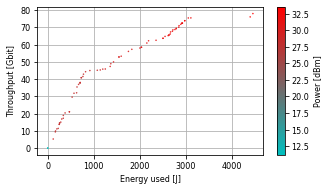

In [28]:
real_power = True

from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from PlotUtil import apply_report_formatting, apply_report_formatting_single
import matplotlib.colors as mcol
import matplotlib.cm as cm

isend_req = 10.69

fig = plt.figure(figsize=(3.2, 2.4))

ax = fig.add_subplot(1,1,1)
ax.grid()
ax.set_axisbelow(True)

x_power = res.X[:, problem.x_indices['power']]
x_power = x_power[:,0]

f_energy = res.F[:,1]
f_throughput = ((res.F[:,0] * -1) / 1e9)   # Gigabit

cm1 = mcol.LinearSegmentedColormap.from_list("BlueRed",["c","r"])

if real_power:
    Ptx_dBm_selected = x_power
else:
    Ptx_dBm_selected = list(map(sys_param.Ptx_dBm_list.__getitem__, x_power.tolist()))

min_Ptx = min(Ptx_dBm_selected)
max_Ptx = max(Ptx_dBm_selected)

cnorm = mcol.Normalize(vmin=min_Ptx,vmax=max_Ptx)

cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

cc = cpick.to_rgba(Ptx_dBm_selected.tolist() if real_power else real_power.to_list())
ax.scatter(f_energy, f_throughput, c=cc, marker='.', s=1)

ax.set_xlabel("Energy used [J]")
ax.set_ylabel("Throughput [Gbit]")
cb = plt.colorbar(cpick,label="Power [dBm]")
cb.ax.tick_params(labelsize=8)
cb.ax.yaxis.label.set_size(8)
apply_report_formatting(4.72, 2.76)
plt.tight_layout()
plt.show()


plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.pdf' % postfix)
plt.savefig('D:/git/thesis_report_ae/figures/link_budget_pareto%s.svg' % postfix)
plt.close()


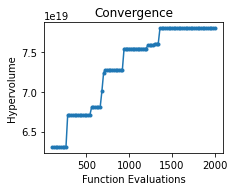

In [29]:
fig = plt.figure(figsize=(3.2, 2.4))

import matplotlib.pyplot as plt
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([0,1e9]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# function evaluations at each snapshot
n_evals = np.array([a.evaluator.n_eval for a in res.history])

# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=3)
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()
apply_report_formatting_single()
plt.tight_layout()

plt.savefig('D:/git/thesis_report_ae/figures/hypervolume%s.svg' % postfix)
plt.savefig('D:/git/thesis_report_ae/figures/hypervolume%s.pgf' % postfix)
plt.close()